In [77]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import tensorflow as tf

In [78]:
def augment(x):
    
    shift = np.random.randint(-5, 5)
    l = x.shape[0]
    if shift >= 0:
        xn = np.zeros_like(x) + x[0:1]
        xn[shift:] = x[:l-shift]
    else:
        xn = np.zeros_like(x) + x[:,-1:]
        xn[:shift,0] = x[-shift:,0]
    return xn + (np.random.random(size=(1,1)) - 0.5) * 0.05

In [79]:
def get_2N(data):
    d1 = []
    d2 = []
    for d in data:
        d1.append(augment(d))
        d2.append(augment(d))
    return tf.stack(d1,axis=0),tf.stack(d2,axis=0)

In [156]:
all_b = []
all_l = []
len_data = 50
a = np.linspace(0, 10, num=len_data)
#for type in np.random.choice(6, 1000, p=[0.2, 0.1, 0.1, 0.2, 0.2, 0.2]):
for type in np.random.choice(6, 5000, p=[0.2, 0.1, 0.1, 0.1, 0.1, 0.4]):

    offset = (np.random.random() - 0.5) * 5 + 5
    all_l.append(type)

    if type == 0:
        b = np.exp(-(a - offset)**2)
    elif type == 1:
        b = -np.exp(-(a - offset)**2)
    elif type == 2:
        b = np.exp(-(a - offset)**2 / 10)
    elif type == 3:
        b = -np.exp(-(a - offset)**2 / 10)
    elif type == 4:
        b1 = np.exp(-(a - offset)**2 / 10)
        b2 = -np.exp(-(a - offset)**2)
        b = b1 + b2
    else:
        b1 = -np.exp(-(a - offset)**2 / 10)
        b2 = np.exp(-(a - offset)**2)
        b = b1 + b2

    b += (np.random.random(len_data) - 0.5) * 0.05
    all_b.append(b)
    
data_org = np.array(all_b, dtype=np.float32)
data_org = np.expand_dims(data_org, 2)
# data_org = np.expand_dims(data_org, 1)
labels = np.array(all_l)

unq, unq_index = np.unique(labels, return_index=True)

print("d_shape", data_org.shape)
print("l_shape", labels.shape)

d_shape (5000, 50, 1)
l_shape (5000,)


In [157]:
def Cosine_similarity(a,b):
    similarity = tf.reduce_sum(a[:, tf.newaxis] * b, axis=-1)
    # Only necessary if vectors are not normalized
    similarity /= tf.norm(a[:, tf.newaxis], axis=-1) * tf.norm(b, axis=-1)
    # If you prefer the distance measure
    return similarity[:,0,:]


In [164]:
@tf.function
def calculate_loss(o1,o2):
    N = o1.shape[0]
    sim_all = Cosine_similarity(tf.expand_dims(o1,1),tf.expand_dims(o2,0))
    
    exp_all = tf.exp(sim_all)
    exp_all = tf.cast(exp_all,tf.float32)
    mask= tf.eye(N)
    nom_all  = mask * exp_all
    nom_all = tf.reduce_sum(nom_all,axis=1) * 2
    
    mask_inv = 1 - mask
    exp_all = exp_all * mask_inv
    
    sum_dist_all = tf.reduce_sum(exp_all,axis=1) + tf.reduce_sum(exp_all,axis=0)
    
    loss_all = -tf.math.log(nom_all/(nom_all+sum_dist_all))
    loss = tf.reduce_sum(loss_all)
    
    return loss

In [159]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, ReLU, Dense,Flatten

In [160]:
class encoderc(Model):
    def __init__(self):
        super(encoderc, self).__init__()
        #Define Layers
        #defualt initializer for Conv1D is 'glorot_uniform' similar to 
        # 'Xavier initializer'

        self.layer1 = Conv1D(8,5,strides=2,input_shape=(50,1))
        self.layer2 = Conv1D(16,5,strides=2)
        self.layer3 = Conv1D(32,3, strides=2)
        self.layer4 = Conv1D(64,3, strides=2)
        self.layer5 = Dense(32)
        self.layer6 = Dense(2)
        
    def __call__(self,x):
        e = tf.nn.relu(self.layer1(x))
        e = tf.nn.relu(self.layer2(e))
        e = tf.nn.relu(self.layer3(e))
        e = tf.nn.relu(self.layer4(e))
        e = Flatten()(e)
        e = tf.nn.relu(self.layer5(e))
        e = self.layer6(e)
        
        return e
        
model = encoderc() 
    
    

In [161]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)

In [168]:
num_epochs = 100
batch_size = 128

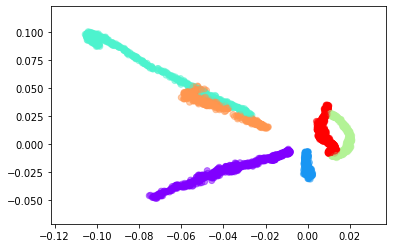

epoch [1/100], loss:11.0789
epoch [2/100], loss:11.7771
epoch [3/100], loss:10.9514
epoch [4/100], loss:11.6902
epoch [5/100], loss:12.9849
epoch [6/100], loss:12.3131
epoch [7/100], loss:10.8831
epoch [8/100], loss:11.4211
epoch [9/100], loss:11.3803
epoch [10/100], loss:11.8935


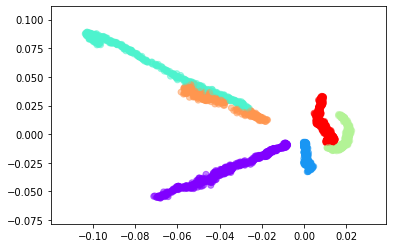

epoch [11/100], loss:11.4543
epoch [12/100], loss:11.8832
epoch [13/100], loss:11.1307
epoch [14/100], loss:10.8427
epoch [15/100], loss:11.5958
epoch [16/100], loss:11.9859
epoch [17/100], loss:11.4977
epoch [18/100], loss:10.9157
epoch [19/100], loss:11.0276
epoch [20/100], loss:10.8573


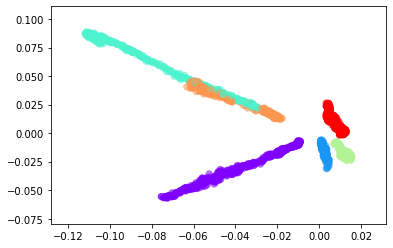

epoch [21/100], loss:13.3892
epoch [22/100], loss:10.6995
epoch [23/100], loss:11.5847
epoch [24/100], loss:12.2360
epoch [25/100], loss:11.1130
epoch [26/100], loss:12.7102
epoch [27/100], loss:12.7604
epoch [28/100], loss:11.3265
epoch [29/100], loss:12.2511
epoch [30/100], loss:11.1530


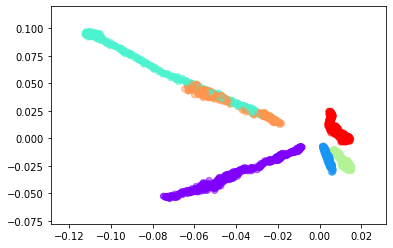

epoch [31/100], loss:11.7170
epoch [32/100], loss:10.6465
epoch [33/100], loss:11.0670
epoch [34/100], loss:11.2483
epoch [35/100], loss:11.4837
epoch [36/100], loss:10.9748
epoch [37/100], loss:11.7533
epoch [38/100], loss:11.3284
epoch [39/100], loss:11.2575
epoch [40/100], loss:11.9451


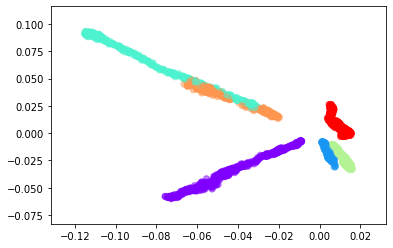

epoch [41/100], loss:11.2632
epoch [42/100], loss:11.2490
epoch [43/100], loss:11.7192
epoch [44/100], loss:11.0734
epoch [45/100], loss:11.9219
epoch [46/100], loss:10.8337
epoch [47/100], loss:12.0864
epoch [48/100], loss:11.5728
epoch [49/100], loss:11.0116
epoch [50/100], loss:10.8595


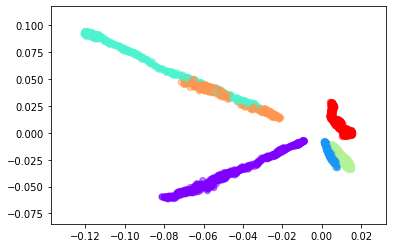

epoch [51/100], loss:13.1866
epoch [52/100], loss:10.9525
epoch [53/100], loss:11.1858
epoch [54/100], loss:10.6273
epoch [55/100], loss:11.1418
epoch [56/100], loss:11.1082
epoch [57/100], loss:11.0002
epoch [58/100], loss:11.4665
epoch [59/100], loss:10.9665
epoch [60/100], loss:12.3525


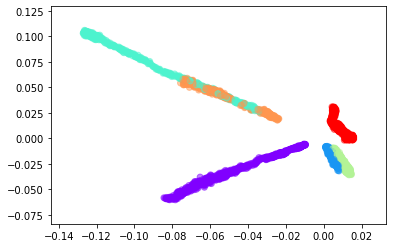

epoch [61/100], loss:13.0216
epoch [62/100], loss:11.4030
epoch [63/100], loss:11.4299
epoch [64/100], loss:10.6501
epoch [65/100], loss:10.6448
epoch [66/100], loss:11.4391
epoch [67/100], loss:12.6461
epoch [68/100], loss:11.2035
epoch [69/100], loss:10.6950
epoch [70/100], loss:11.6853


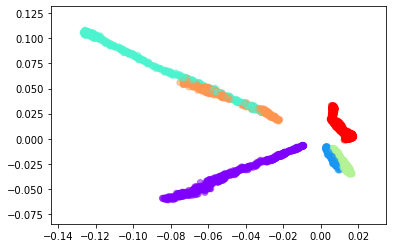

epoch [71/100], loss:11.3785
epoch [72/100], loss:11.4302
epoch [73/100], loss:10.8483
epoch [74/100], loss:10.8238
epoch [75/100], loss:11.3941
epoch [76/100], loss:11.9105
epoch [77/100], loss:12.7315
epoch [78/100], loss:12.6803
epoch [79/100], loss:11.1730
epoch [80/100], loss:10.6779


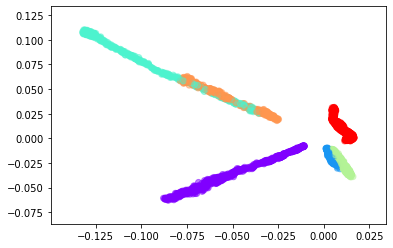

epoch [81/100], loss:11.9732
epoch [82/100], loss:11.3520
epoch [83/100], loss:10.9815
epoch [84/100], loss:10.8421
epoch [85/100], loss:11.0689
epoch [86/100], loss:11.3421
epoch [87/100], loss:10.7212
epoch [88/100], loss:10.8430
epoch [89/100], loss:11.5079
epoch [90/100], loss:11.1306


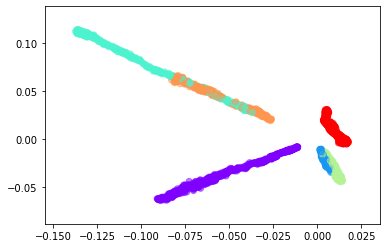

epoch [91/100], loss:11.8204
epoch [92/100], loss:10.7262
epoch [93/100], loss:11.0406
epoch [94/100], loss:12.0788
epoch [95/100], loss:12.6619
epoch [96/100], loss:11.4596
epoch [97/100], loss:12.2991
epoch [98/100], loss:11.3654
epoch [99/100], loss:10.9956
epoch [100/100], loss:11.2697


In [169]:
for epoch in range(num_epochs):
    idx = np.random.permutation(len(data_org))
    data_org = data_org[idx]
    labels = labels[idx]
    
    if epoch % 10 == 0:
        o_all = model(data_org)
        oan = o_all.numpy()
        
        plt.scatter(oan[:,0],oan[:,1], c=labels,cmap='rainbow',alpha=0.5)
        plt.show()
    
    for idx in range(0,len(data_org), batch_size):
        data = data_org[idx:idx+batch_size]
        
        d1,d2 = get_2N(data)
        
        #forward
        with tf.GradientTape() as tape:
            o1 = model(d1)
            o2 = model(d2)
            loss = calculate_loss(o1,o2)
        
        grads = tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1,num_epochs,loss))
        